# Movie Success Prediction with Trailers

## 1. Problem Definition

**Problem statement**
<br>The success of a movie can be predicated using social media analytics. The audience expectations and movie buzz can be measured from the data gathered via social media platforms. Video-sharing websites like YouTube encourages interaction among its users through the provision of user reviewing facility of movie trailers. In this project, I gather data about movie trailers by scraping the internet and using API's from different sources. I then build a model that uses this dataset (things like online search trends prior to release date, etc) to predict the initial success of a movie.

**Features**
1. title: movie's title.
2. genres: movie's genres.
3. production_companies: movie's list of production companies.
4. production_countries: movie's list of production countires.
5. release_date: movie's release data.
6. runtime: movie duration in minutes (we restrict to movies with at least 80 minutes long).
7. budget: movie's budget (excluding marketing costs, which are typically as large as the budget itself).
8. num_peaks: number of online search peaks from Google Trends corresponding to a movie trailer. 
9. search_volume: area under the curve in the Google trends data.
10. views: movie's mean number of Youtube trailer views.
11. likes: movie's mean number of Youtube trailer likes.
12. dislikes: movie's mean number of Youtube trailer dislikes.
13. dt_main: number of days between the Youtube trailer with largest search volume and the movie's release date.
14. dt_trailers: number of days between the two most popular Youtube trailers for a movie. dt_trailers=0 if the movie only has one trailer, dt_trailers<0 if the first trailer was has the largest search volume.

**Target**
<br>$success = \frac{opening \ weekend \ revenue}{budget}$

**Machine learning**
<br>1, Predict movie success (target) for based on given informations (features) by applying different models
<br>2, Choose the best model (model performance) and interpret the predicted success (feature importance)

**Metrics**
<br>Model performance can be evaluated in different ways, here R2 score is used
<br>R2 score: the proportion of the variance in the dependent variable (target) that is predictable from the independent variables (features). R2 score is no greater than 1 and the higher R2 the better model performance. A negative R2 score suggests that the model performance is worse than mean value prediction, and R2 score of 1 indicates a perfect prediction.
<br>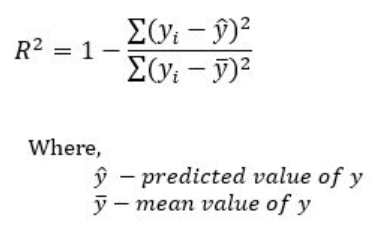

## 2. Pre-model Analysis

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import make_scorer, r2_score
from xgboost import XGBRegressor
import matplotlib.pylab as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

np.random.seed(42)

### 2.1 Get data

In [2]:
df = pd.read_csv('data/df_movies.csv')

In [3]:
df.columns

Index(['title', 'genres', 'production_companies', 'production_countries',
       'release_date', 'runtime', 'budget', 'num_peaks', 'search_volume',
       'views', 'likes', 'dislikes', 'dt_main', 'dt_trailers', 'success'],
      dtype='object')

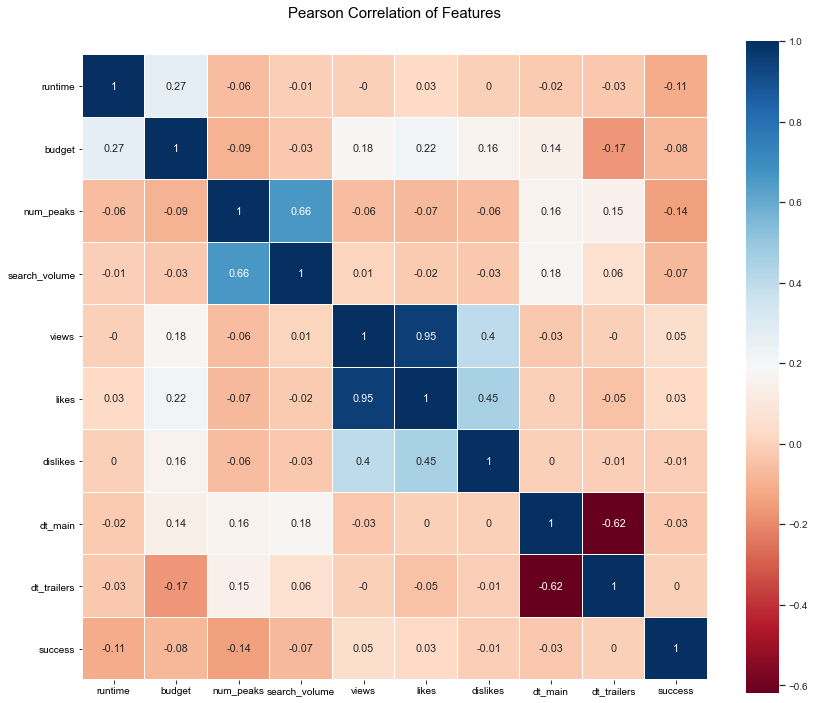

In [4]:
def pea_corr(df):
    '''helper function for correlation analysis'''
    colormap = plt.cm.RdBu
    corr = df.astype(float).corr()

    plt.figure(figsize=(14,12))
    plt.title('Pearson Correlation of Features', y=1.05, size=15)
    sns.set(font_scale=0.9)
    sns.heatmap(round(corr,2),linewidths=0.1,vmax=1.0, square=True, 
                cmap=colormap, linecolor='white', annot=True)
    plt.show()

pea_corr(df[df.corr().columns])

In [5]:
df.corr()['success'].sort_values(ascending = False)

success          1.000000
views            0.047513
likes            0.032664
dt_trailers      0.002489
dislikes        -0.012641
dt_main         -0.034232
search_volume   -0.070712
budget          -0.084779
runtime         -0.111369
num_peaks       -0.135409
Name: success, dtype: float64

* All these indiviual features are not very linearly correlated with success. Need to do some feature engineering for a better prediction model.

### 2.2 Youtube views, likes, dislikes

* Youtube views, likes, dislikes are highly correlated. Plot the distribution are correlation among these features.

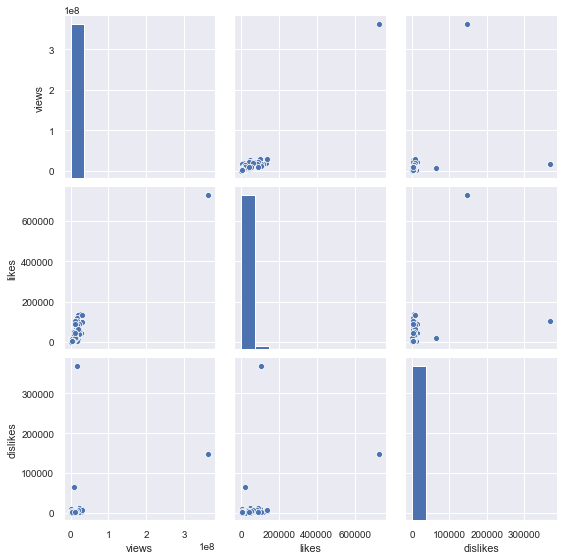

In [6]:
attributes = ['views', 'likes', 'dislikes']
sns.pairplot(df[attributes])
plt.show()

* The ditributions of dislikes, likes and view are highly screwed. Genertate log of these features.

In [7]:
df['log_views'] = df[df.views!=0].views.apply(np.log)
df['log_likes'] = df[df.likes!=0].likes.apply(np.log)
df['log_dislikes'] = df[df.dislikes!=0].dislikes.apply(np.log)

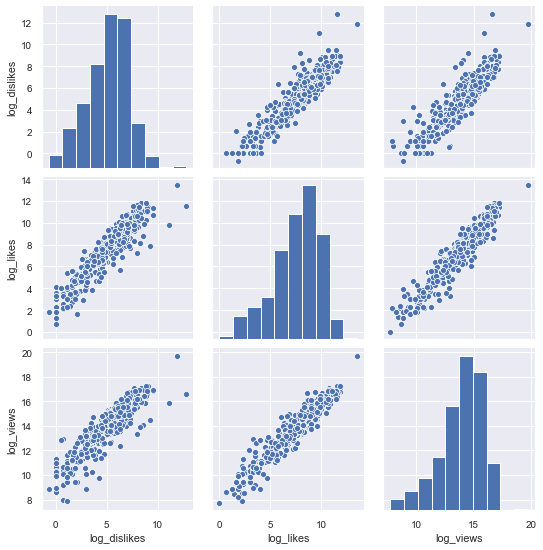

In [8]:
attributes = ['log_dislikes', 'log_likes', 'log_views']
sns.pairplot(df[attributes])
plt.show()

* We see that the logs of likes, dislikes and views are highly correlated. We can therefore use only one of these feature when building a machine learning model.

### 2.3 Production countries

In [9]:
# create list that includes all countries involved in the movie data set
countries = df.apply(lambda x: pd.Series(x['production_countries']),axis=1).stack().reset_index(level=1, drop=True)
countries.name = 'countries'

countries_df = df.drop('production_countries', axis=1).join(countries)
countries_df = pd.DataFrame(countries_df['countries'].value_counts())
countries_df['country'] = countries_df.index
countries_df.columns = ['num_movies', 'country']
countries_df = countries_df.reset_index().drop('index', axis=1)
countries_df.head(10)
countries_df = countries_df[countries_df['country'] != 'United States of America']

countries_df.head()

,num_movies,country
0,400,['United States of America']
1,24,"['United Kingdom', 'United States of America']"
2,16,"['Canada', 'United States of America']"
3,7,"['France', 'United States of America']"
4,4,"['Australia', 'United States of America']"


* Majority of the movies are produced in USA. Thus this feature not important for prediction.

### 2.4 Production companies

In [10]:
s = df.apply(lambda x: pd.Series(x['production_companies']),axis=1).stack().reset_index(level=1, drop=True)
s.name = 'companies'

com_df = df.drop('production_companies', axis=1).join(s)

com_sum = pd.DataFrame(com_df.groupby('companies')['success'].sum().sort_values(ascending=False))
com_sum.columns = ['Total']
com_mean = pd.DataFrame(com_df.groupby('companies')['success'].mean().sort_values(ascending=False))
com_mean.columns = ['Average']
com_count = pd.DataFrame(com_df.groupby('companies')['success'].count().sort_values(ascending=False))
com_count.columns = ['Number']

com_pivot = pd.concat((com_sum, com_mean, com_count), axis=1)

com_pivot.sort_values(by="Average", ascending = False).head()

,Total,Average,Number
"['Paramount Pictures', 'Blumhouse Productions', 'Solana Films']",13.559475,13.559475,1
"['Alliance Films', 'IM Global', 'Stage 6 Films', 'Haunted Movies']",8.847643,8.847643,1
"['Paramount Pictures', 'Blumhouse Productions', 'Room 101', 'Solana Films']",16.314410,8.157205,2
"['Alliance Films', 'Blumhouse Productions', 'IM Global', 'Automatik Entertainment', 'Possessed Pictures']",6.002545,6.002545,1
"['Extension 765', 'Iron Horse Entertainment (II)']",5.589596,5.589596,1


* Seems like studios that produce predominantly horror films have large success rates. We will explore this more below when we look into the genres.

### 2.5 Release date

In [11]:
date = pd.to_datetime(df["release_date"])
df["weekday"] = date.dt.weekday
df["month"] = date.dt.month

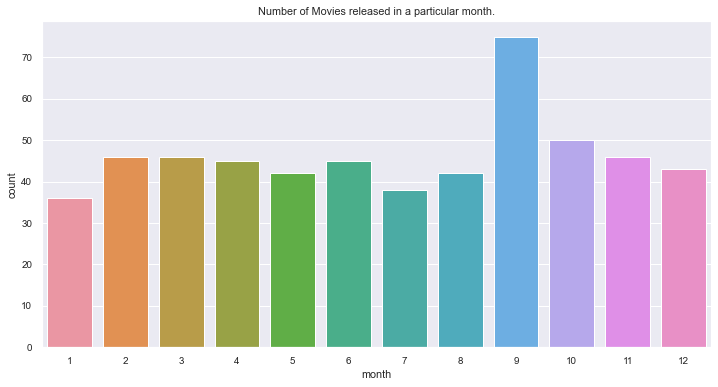

In [12]:
plt.figure(figsize=(12,6))
plt.title("Number of Movies released in a particular month.")
sns.countplot(x='month', data=df)
plt.show()

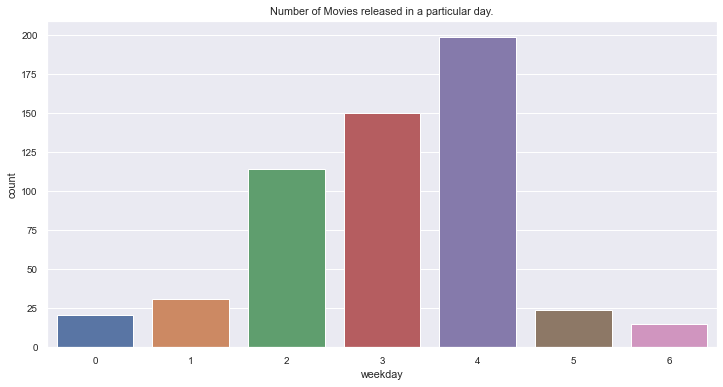

In [13]:
plt.figure(figsize=(12,6))
plt.title("Number of Movies released in a particular day.")
sns.countplot(x='weekday', data=df)
plt.show()

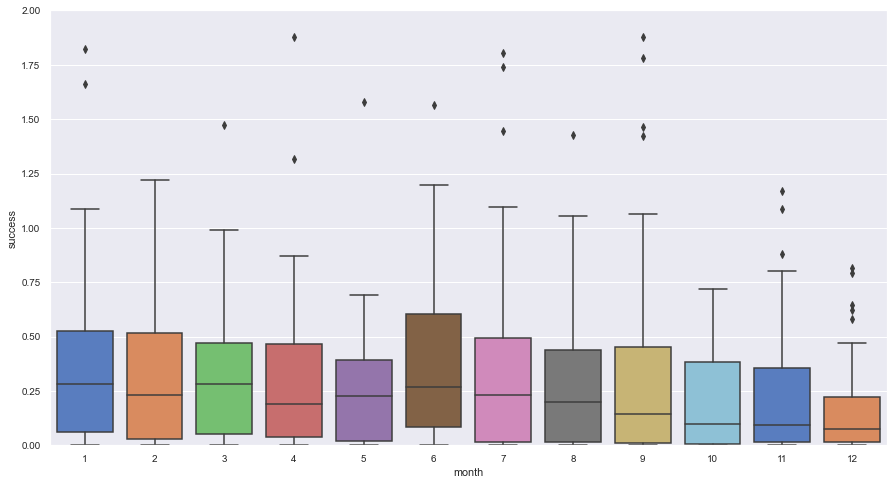

In [14]:
fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(15, 8))
sns.boxplot(x='month', y='success', data=df[df['success'].notnull()], palette="muted", ax =ax)
ax.set_ylim([0, 2])
plt.show()

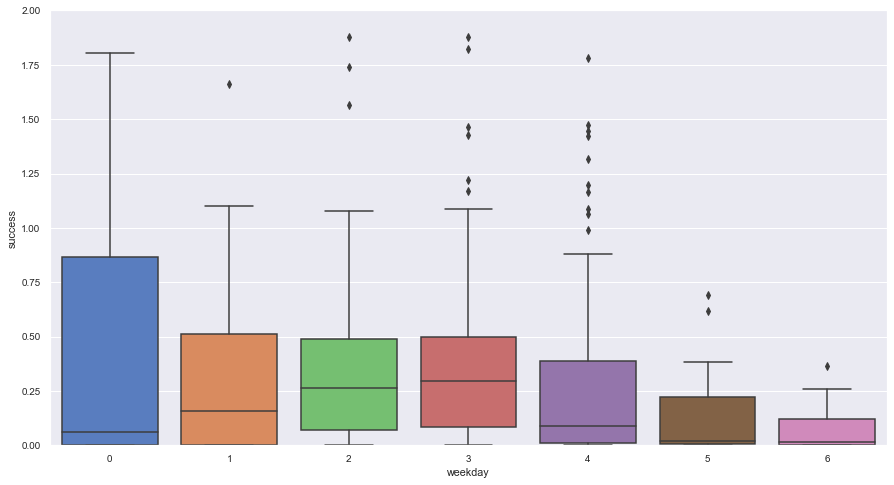

In [15]:
fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(15, 8))
sns.boxplot(x='weekday', y='success', data=df[df['success'].notnull()], palette="muted", ax =ax)
ax.set_ylim([0, 2])
plt.show()

### 2.6 Budget

In [16]:
df['budget'].describe()

count    5.540000e+02
mean     3.807791e+07
std      4.286572e+07
min      1.030064e+06
25%      9.000000e+06
50%      2.000000e+07
75%      5.000000e+07
max      2.090000e+08
Name: budget, dtype: float64

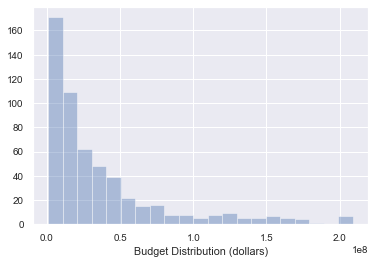

In [17]:
p = sns.distplot(df['budget'], kde=False)
p.set_xlabel('Budget Distribution (dollars)')
plt.show()

* The ditribution of budget is highly screwed. Genertate log of budget.

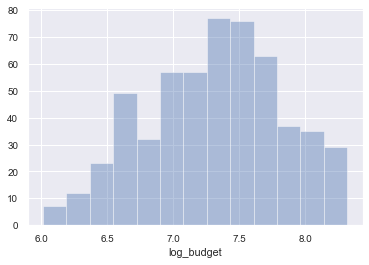

In [18]:
df['log_budget']= df['budget'].apply(np.log10)
sns.distplot(df['log_budget'], kde=False)
plt.show()

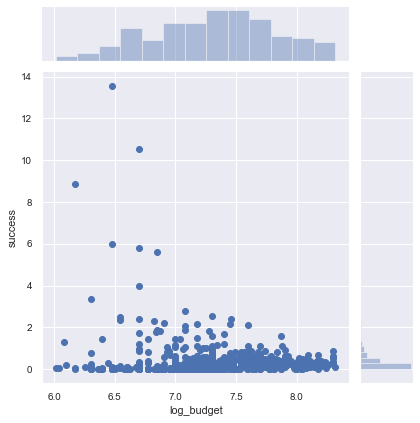

In [19]:
#budget and success correlation
p=sns.jointplot(df['log_budget'], df['success'])
plt.show()

* Surprisingly, there are several movies with smaller budgets that have higher 'success' than average. As we now see, these outliers are mostly horror films.

### 2.7 Genre

Let us explore the movie genres. Does one genre correlate more with success than the rest?

In [20]:
df["genres"] = df["genres"].apply(lambda x: x.strip("[").strip("]").replace("'","").replace(" ","").split(","))
s = df.apply(lambda x: pd.Series(x['genres']),axis=1).stack().reset_index(level=1, drop=True)
s.name = 'genre'

gen_df = df.drop('genres', axis=1).join(s)
pop_gen = pd.DataFrame(gen_df['genre'].value_counts()).reset_index()
pop_gen.columns = ['genre', 'movies']

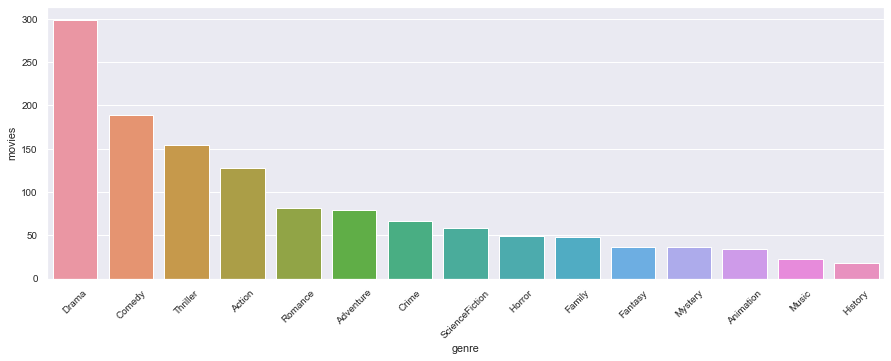

In [21]:
#plot genre distribution 
plt.figure(figsize=(15,5))
sns.barplot(x='genre', y='movies', data=pop_gen.head(15))
plt.xticks(rotation=45)
plt.show()

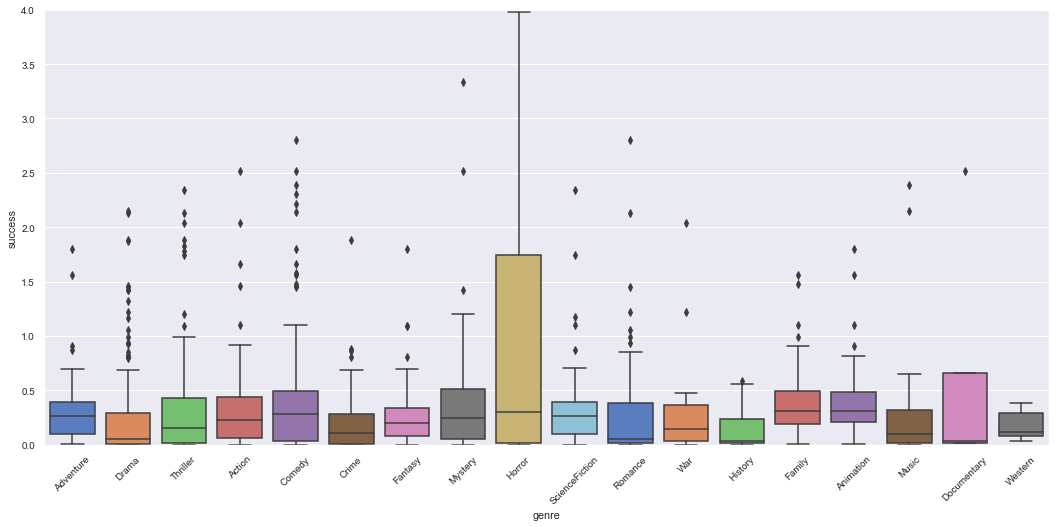

In [22]:
plt.figure(figsize=(18,8))
genres = pop_gen["genre"]
pop_gen_movies = gen_df[(gen_df['genre'].isin(genres))]
sns.boxplot(x='genre', y='success', data=pop_gen_movies, palette="muted")
plt.ylim([0, 4])
plt.xticks(rotation=45)
plt.show()

* Low budget horror films aparently can lead to success! Indeed, the movie paranormal activity had a budget of 3 million dollars and generated about 40 million on opening weekend.

In [23]:
# one-hot encoding genres
for genre in pop_gen["genre"]:
    df["g_" + genre] = 0
    for idx in range(len(df)):
        if genre in df["genres"][idx]:
            df["g_" + genre][idx] = 1

### 2.8 Runtime

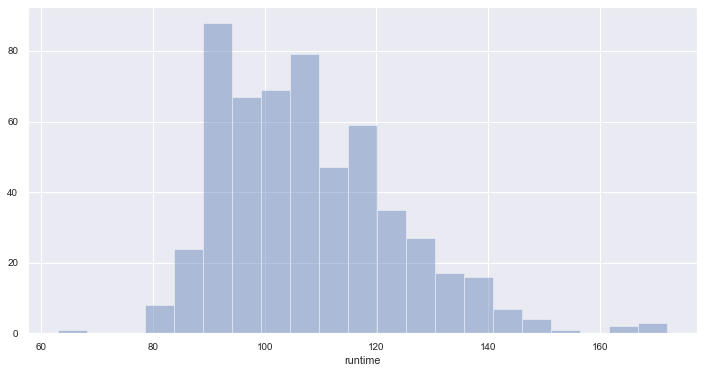

In [24]:
plt.figure(figsize=(12,6))
sns.distplot(df[(df['runtime'] < 300) & (df['runtime'] > 0)]['runtime'], kde=False)
plt.show()

* Most movies run for more than 80 minutes. 

### 2.9 Google trends

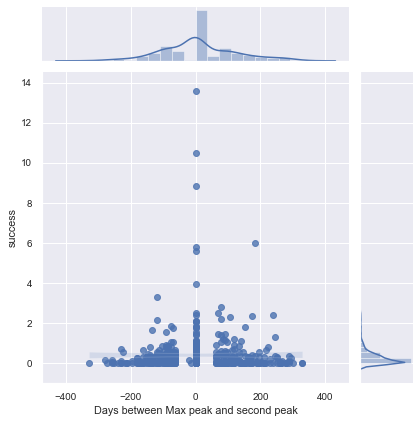

In [25]:
# relation between success and days between max peak and second peak
p=sns.jointplot('dt_trailers', 'success', data=df, kind='reg')
p.set_axis_labels('Days between Max peak and second peak', 'success')
plt.show()

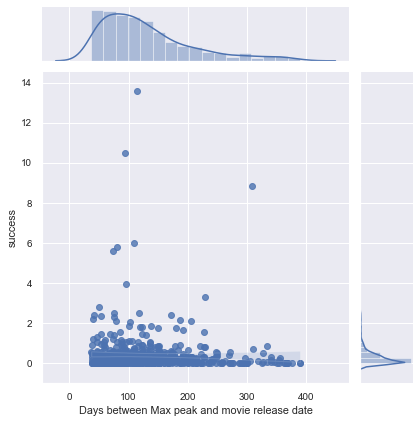

In [26]:
# relation between success and days between max peak and movie release date
p=sns.jointplot('dt_main', 'success', data=df, kind='reg')
p.set_axis_labels('Days between Max peak and movie release date', 'success')
plt.show()

### 2.10 Finalize the data set

* Create a trailer viewership score by rescaling views by the (normalized) search volume from google trends and accounting for the likes/dislikes ratio

view_score = $\ln\left(views \times search\_volume \times \frac{likes - dislikes}{likes + dislikes}\right)$

In [27]:
# apply constrains to get rid of outliers
df = df[df.success<=3]
df = df[df.budget>=10000000]
df = df[df.runtime>80]
df.shape

(405, 39)

In [28]:
df.eval('view_score = views*(likes - dislikes)/(likes + dislikes)*search_volume', 
        inplace=True)
df["view_score"] = df["view_score"].apply(np.log)

* Drop some features

In [29]:
df = df.drop(['title', 'genres', 'production_companies', 'production_countries', 
              'release_date', 'views', 'likes', 'dislikes', 'budget'], axis=1)
df = df.dropna()

* Final dataframe for modeling

In [30]:
df.head()

,runtime,num_peaks,search_volume,dt_main,dt_trailers,success,log_views,log_likes,log_dislikes,weekday,...,g_Family,g_Fantasy,g_Mystery,g_Animation,g_Music,g_History,g_War,g_Western,g_Documentary,view_score
0,94,1,335,75,0,0.014714,15.674990,9.605587,5.876334,4,...,0,0,0,0,0,0,0,0,0,21.441090
1,109,2,666,124,-70,0.443592,11.823134,6.343880,2.944439,4,...,0,0,0,0,0,0,0,0,0,18.257615
3,109,1,483,134,0,0.864348,15.149918,8.814330,5.762051,0,...,0,0,0,0,0,0,0,0,0,21.235362
4,83,2,544,116,0,0.476076,12.361314,6.399427,3.238678,3,...,0,0,0,0,0,0,0,0,0,18.575425
5,128,2,1058,89,112,0.687179,12.189728,6.453100,3.232121,4,...,0,0,0,0,0,0,0,0,0,19.073989


## 3. Model Building

### 3.1 Prepare date sets and models

In [31]:
# Creat train and test data sets
X, y = df.drop('success', axis=1), df['success'].copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [32]:
# Three base models: linear regression, random forest and xgboost

steps_lr = [("scale", MinMaxScaler()), ("lr", LinearRegression())]
steps_xgb = [("scale", RobustScaler()), ("xbg", XGBRegressor(random_state=42, n_jobs=-1, objective='reg:squarederror'))]

model_lr = Pipeline(steps_lr)
model_xgb = Pipeline(steps_xgb)

### 3.2 Model validation

Let us train a tree based ensemble method: XGBoost with default parameters. We apply 10-fold crossvalidation to reveal that this model is relatively stable with a stdev~0.07 around the rmse. 

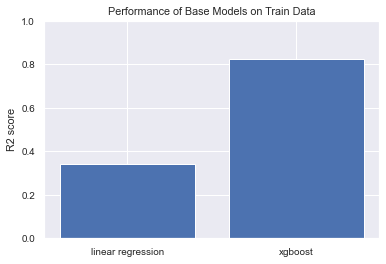

In [33]:
# Compare the base models

models = {"linear regression": model_lr, "xgboost": model_xgb}
train_res = {}

for name, model in models.items():
    model = model.fit(X_train, y_train)
    y_train_pred = model.predict(X_train)
    train_res[name] = r2_score(y_train, y_train_pred)
    
fig_train = plt.figure()
plt.bar(train_res.keys(), train_res.values())
plt.title("Performance of Base Models on Train Data")
plt.ylabel("R2 score")
plt.ylim(0, 1)
plt.show()

**Base model selection**
<br>Comparing the R2 scores of the two base models on both train data, xgboost gives better performance. Hence xgboost is chose as our base model. Hyper parameter tuning will be conducted to further improve the model performance.

In [38]:
# Gridserach to find the best hyper parameters

params = {
     "xgb__n_estimators": [100, 300],
     "xgb__reg_alpha": range(5, 20)[::2],
     "xgb__reg_lambda": range(50, 201)[::10]
}


steps = [("scale", RobustScaler()),
         ("xgb", XGBRegressor(random_state=42, objective='reg:squarederror'))]

model = Pipeline(steps)

scorer = make_scorer(r2_score)

clf = GridSearchCV(model, params, scoring=scorer)

clf.fit(X_train, y_train)

results = clf.cv_results_
best_model = clf.best_estimator_

In [39]:
best_model

Pipeline(steps=[('scale', RobustScaler()),
                ('xgb',
                 XGBRegressor(n_estimators=300, objective='reg:squarederror',
                              random_state=42, reg_alpha=5, reg_lambda=190))])

### 3.3 Model predictions

In [40]:
model = best_model.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
print("Train R2: {:.3f}".format(r2_score(y_train, y_train_pred)))
y_test_pred = model.predict(X_test)
print("Test R2: {:.3f}".format(r2_score(y_test, y_test_pred)))

Train R2: 0.402
Test R2: 0.120


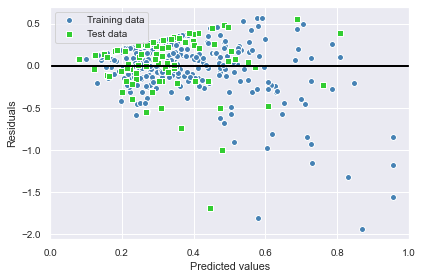

In [41]:
plt.scatter(y_train_pred,  y_train_pred - y_train,
            c='steelblue', marker='o', edgecolor='white',
            label='Training data')
plt.scatter(y_test_pred,  y_test_pred - y_test,
            c='limegreen', marker='s', edgecolor='white',
            label='Test data')
plt.xlabel('Predicted values')

plt.ylabel('Residuals')
plt.legend(loc='upper left')
plt.hlines(y=0, xmin=-10, xmax=50, color='black', lw=2)
plt.xlim([0, 1])
plt.tight_layout()
plt.show()

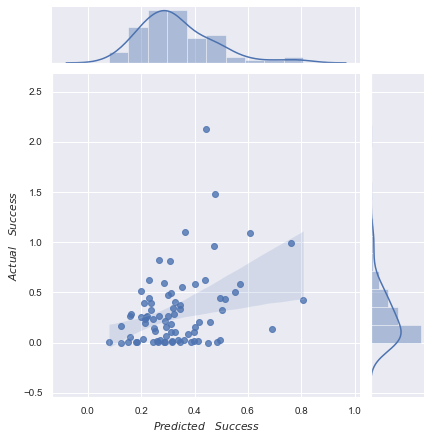

In [42]:
ax.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'k--', lw=4)
p=sns.jointplot(y_test_pred, y_test, kind='reg')
p.set_axis_labels(
    r'$ Predicted\quad Success$', r'$ Actual\quad Success$')
plt.show()

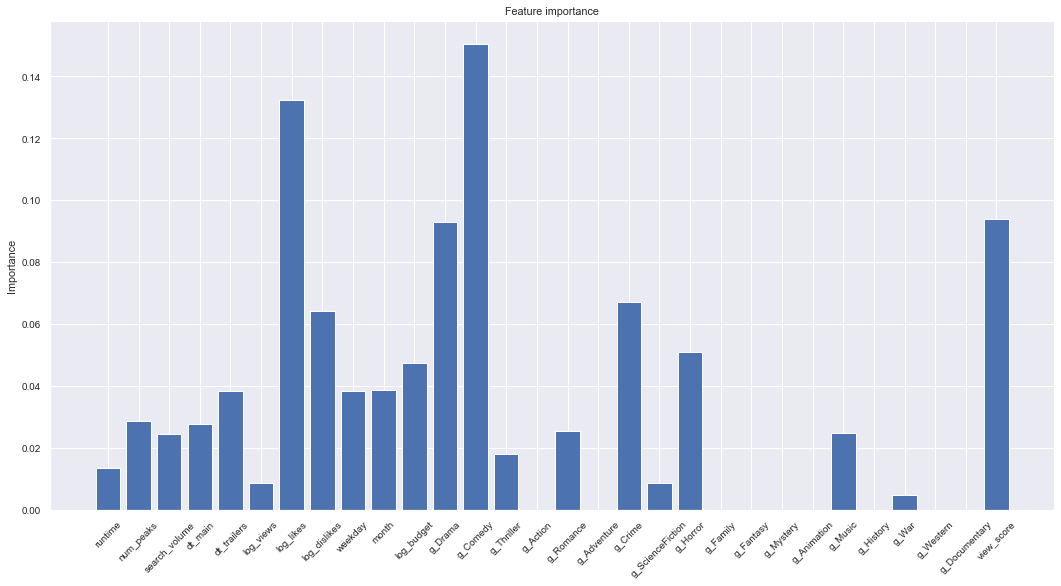

In [43]:
# Feature importance
plt.figure(figsize=(18,9))
fea = X_train.columns
y = model[1].feature_importances_
plt.bar(fea, y)
plt.title("Feature importance")
plt.xticks(rotation=45)
plt.ylabel("Importance")
plt.show()

### 3.4 Summary
1. The most important features for predicting movie success are: genre_comdey, log_likes, genre_drama and view_score
2. Further tunning can be applied for better model performance